In [1]:
from ccgnet import experiment as exp
from ccgnet import layers
import tensorflow as tf
import numpy as np
import time
from ccgnet.Dataset import Dataset

# 1. Make dataset

In [2]:
# first please uncompress data/Mol_Blocks.rar

data = Dataset('./data/Cocrystal_Table.csv', mol_blocks_dir='./data/Mol_Blocks.dir')
df = data.make_graph_dataset(Desc=1, A_type='OnlyCovalentBond', hbond=0, pipi_stack=0, contact=0, make_dataframe=1)

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
RDKit ERROR: [10:54:26] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [10:54:30] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [10:54:31] Can't kekulize mol.  Unkekulized atoms: 2 4 5 7 9
RDKit ERROR: 
RDKit ERROR: [10:54:35] Can't kekulize mol.  Unkekulized atoms: 2 4 6 7 9
RDKit ERROR: 
RDKit ERROR: [10:54:36] Can't kekulize mol.  Unkekulized atoms: 3 5 7 9 11
RDKit ERROR: 
RDKit ERROR: [10:54:36] Can't kekulize mol.  Unkekulized atoms: 0 2 4 6 8
RDKit ERROR: 
RDKit ERROR: [10:54:36] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 8
RDKit ERROR:

Elapsed Time: 112.68 s


In [3]:
from sklearn.model_selection import KFold
cv = np.array(eval(open('./data/CV_Set.list').read()))
test = np.array(eval(open('./data/Test_Set.list').read()))
fold_10 = {}
fold_10['valid'] = test
kf = KFold(n_splits=10, shuffle=True, random_state=1000)
n = 0
for train_idx, test_idx in kf.split(cv):
    fold = 'fold-{}'.format(n)
    fold_10[fold] = {}
    fold_10[fold]['train'] = cv[train_idx]
    fold_10[fold]['test'] = cv[test_idx]
    n += 1

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 2. Build Model

In [4]:
class CCGNet_block(object):
    def build_model(self, inputs, is_training, global_step):
        V = inputs[0]
        A = inputs[1]
        labels = inputs[2]
        mask = inputs[3]
        graph_size = inputs[4]
        tags = inputs[5]
        global_state = inputs[6]
        subgraph_size = inputs[7]
        global_state = tf.reshape(global_state, [-1, int(global_state.get_shape()[-1].value/2)])
        ## Message Passing Phase
        V, global_state = layers.CCGBlock(V, A, global_state, subgraph_size, no_filters=128, mask=mask, num_updates=global_step, is_training=is_training)
        V, global_state = layers.CCGBlock(V, A, global_state, subgraph_size, no_filters=64, mask=mask, num_updates=global_step, is_training=is_training)
        V, global_state = layers.CCGBlock(V, A, global_state, subgraph_size, no_filters=16, mask=mask, num_updates=global_step, is_training=is_training)
        ## Readout Phase
        V = layers.multi_head_global_attention(V, graph_size, num_head=10)
        global_state = tf.reshape(global_state, [-1, 32])
        V = tf.concat([V, global_state], 1)
        V = layers.make_fc_layer(V, 256, is_training=is_training, with_act_func=1, with_bn=1, num_updates=global_step, name='FC')
        out = layers.make_fc_layer(V, 2, with_act_func=0, with_bn=0, name='final',)
        return out, labels

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 3. Training

In [5]:
start = time.time()
model_name = 'CCGNet-block'
dataset_name = 'OnlyCovalentBond'
History = {}
History['test_acc'] = []
History['val_acc'] = []
for fold in ['fold-{}'.format(i) for i in range(10)]:
    print('\n################ {} ################'.format(fold))
    train_data, test_data, val_data = data.split(train_samples=fold_10[fold]['train'], test_samples=fold_10[fold]['test'], val=True, val_samples=fold_10['valid'])
    tf.reset_default_graph()
    model = CCGNet_block()
    model = exp.Model(
                      model, 
                      train_data, 
                      test_data, 
                      val=True, 
                      val_data=val_data, 
                      snapshot_path='./snapshot/', 
                      use_subgraph=True,
                      model_name=model_name, 
                      dataset_name=dataset_name+'/time_{}'.format(fold[-1])
                     )
    
    history = model.fit(num_epoch=100, train_batch_size=256, save_info=True, save_att=True, silence=0)
    History['test_acc'].append(max(history['test_acc']))
    History['val_acc'].append(history['val_acc'])
print('test_mean_acc:{:.4f}(±{:.4f})'.format(np.array(History['test_acc']).mean()*100,np.array(History['test_acc']).std()*100))
print('val_mean_acc:{:.4f}(±{:.4f})'.format(np.array(History['val_acc']).mean()*100,np.array(History['val_acc']).std()*100))
end = time.time()
time_gap = end-start
h = time_gap//3600
h_m = time_gap%3600
m = h_m//60
s = h_m%60
print('{}h {}m {}s'.format(int(h),int(m),round(s,2)))

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



################ fold-0 ################
Instructions for updating:
Colocations handled automatically by placer.


/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Starting summaries
## Epoch 0 ==> Train Loss:0.25038, Train Acc:89.46, Test Loss:0.60349, Test Acc:89.58, Elapsed Time:7.69 s
## Epoch 1 ==> Train Loss:0.09733, Train Acc:96.56, Test Loss:0.54558, Test Acc:87.04, Elapsed Time:4.81 s
## Epoch 2 ==> Train Loss:0.07516, Train Acc:97.46, Test Loss:1.19880, Test Acc:73.24, Elapsed Time:4.51 s
## Epoch 3 ==> Train Loss:0.05181, Train Acc:98.19, Test Loss:0.72818, Test Acc:79.58, Elapsed Time:4.52 s
## Epoch 4 ==> Train Loss:0.03999, Train Acc:98.89, Test Loss:0.81670, Test Acc:77.75, Elapsed Time:4.52 s
## Epoch 5 ==> Train Loss:0.03357, Train Acc:98.88, Test Loss:0.48631, Test Acc:86.06, Elapsed Time:4.48 s
## Epoch 6 ==> Train Loss:0.03139, Train Acc:99.01, Test Loss:0.30725, Test Acc:90.28, Elapsed Time:5.50 s
## Epoch 7 ==> Train Loss:0.02294, Train Acc:99.27, Test Loss:0.52026, Test Acc:84.65, Elapsed Time:4.47 s
## Epoch 8 ==> Train Loss:0.01978, Train A

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.33644, Train Acc:84.13, Test Loss:0.64426, Test Acc:95.06, Elapsed Time:6.49 s
## Epoch 1 ==> Train Loss:0.11035, Train Acc:95.93, Test Loss:0.44978, Test Acc:95.49, Elapsed Time:6.03 s
## Epoch 2 ==> Train Loss:0.07643, Train Acc:97.32, Test Loss:0.21773, Test Acc:97.18, Elapsed Time:5.31 s
## Epoch 3 ==> Train Loss:0.05866, Train Acc:98.21, Test Loss:0.14257, Test Acc:97.18, Elapsed Time:4.48 s
## Epoch 4 ==> Train Loss:0.04524, Train Acc:98.66, Test Loss:0.11432, Test Acc:97.74, Elapsed Time:5.35 s
## Epoch 5 ==> Train Loss:0.03456, Train Acc:98.95, Test Loss:0.10615, Test Acc:97.18, Elapsed Time:4.58 s
## Epoch 6 ==> Train Loss:0.03057, Train Acc:99.04, Test Loss:0.09997, Test Acc:97.04, Elapsed Time:4.51 s
## Epoch 7 ==> Train Loss:0.02721, Train Acc:99.19, Test Loss:0.08476, Test Acc:97.60, Elapsed Time:4.59 s
## Epoch 8 ==> Train Loss:0.02550, Train Acc:99.19, Test Loss:0.10394

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.18659, Train Acc:93.77, Test Loss:0.39374, Test Acc:95.06, Elapsed Time:6.51 s
## Epoch 1 ==> Train Loss:0.09096, Train Acc:96.84, Test Loss:0.17700, Test Acc:96.61, Elapsed Time:5.67 s
## Epoch 2 ==> Train Loss:0.06332, Train Acc:97.84, Test Loss:0.20582, Test Acc:96.90, Elapsed Time:5.80 s
## Epoch 3 ==> Train Loss:0.05277, Train Acc:98.06, Test Loss:0.48099, Test Acc:93.65, Elapsed Time:4.48 s
## Epoch 4 ==> Train Loss:0.03756, Train Acc:98.76, Test Loss:0.09024, Test Acc:97.18, Elapsed Time:5.62 s
## Epoch 5 ==> Train Loss:0.03039, Train Acc:99.07, Test Loss:0.08747, Test Acc:97.46, Elapsed Time:5.59 s
## Epoch 6 ==> Train Loss:0.02900, Train Acc:98.97, Test Loss:0.08033, Test Acc:97.74, Elapsed Time:5.33 s
## Epoch 7 ==> Train Loss:0.02429, Train Acc:99.11, Test Loss:0.08342, Test Acc:97.88, Elapsed Time:5.33 s
## Epoch 8 ==> Train Loss:0.02146, Train Acc:99.29, Test Loss:0.09159

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.23441, Train Acc:92.32, Test Loss:0.24598, Test Acc:96.33, Elapsed Time:6.99 s
## Epoch 1 ==> Train Loss:0.08474, Train Acc:97.11, Test Loss:0.10987, Test Acc:97.32, Elapsed Time:6.25 s
## Epoch 2 ==> Train Loss:0.06155, Train Acc:97.87, Test Loss:0.12478, Test Acc:97.04, Elapsed Time:5.11 s
## Epoch 3 ==> Train Loss:0.04362, Train Acc:98.62, Test Loss:0.11533, Test Acc:97.04, Elapsed Time:4.98 s
## Epoch 4 ==> Train Loss:0.03807, Train Acc:98.72, Test Loss:0.03782, Test Acc:98.87, Elapsed Time:5.83 s
## Epoch 5 ==> Train Loss:0.02800, Train Acc:99.20, Test Loss:0.04015, Test Acc:98.59, Elapsed Time:5.14 s
## Epoch 6 ==> Train Loss:0.02085, Train Acc:99.41, Test Loss:0.02843, Test Acc:98.73, Elapsed Time:5.04 s
## Epoch 7 ==> Train Loss:0.01915, Train Acc:99.47, Test Loss:0.03758, Test Acc:99.01, Elapsed Time:5.95 s
## Epoch 8 ==> Train Loss:0.01765, Train Acc:99.41, Test Loss:0.04912

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.20074, Train Acc:93.07, Test Loss:0.39430, Test Acc:91.82, Elapsed Time:7.26 s
## Epoch 1 ==> Train Loss:0.09099, Train Acc:96.89, Test Loss:0.24801, Test Acc:93.23, Elapsed Time:6.60 s
## Epoch 2 ==> Train Loss:0.06259, Train Acc:97.78, Test Loss:0.59972, Test Acc:87.02, Elapsed Time:5.13 s
## Epoch 3 ==> Train Loss:0.04188, Train Acc:98.73, Test Loss:0.57911, Test Acc:86.88, Elapsed Time:5.14 s
## Epoch 4 ==> Train Loss:0.03400, Train Acc:98.81, Test Loss:0.55146, Test Acc:86.32, Elapsed Time:5.13 s
## Epoch 5 ==> Train Loss:0.02651, Train Acc:99.17, Test Loss:0.34891, Test Acc:90.55, Elapsed Time:5.12 s
## Epoch 6 ==> Train Loss:0.02295, Train Acc:99.23, Test Loss:0.43390, Test Acc:89.00, Elapsed Time:5.12 s
## Epoch 7 ==> Train Loss:0.02241, Train Acc:99.26, Test Loss:0.30528, Test Acc:91.11, Elapsed Time:5.12 s
## Epoch 8 ==> Train Loss:0.01906, Train Acc:99.42, Test Loss:0.23502

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.25675, Train Acc:89.33, Test Loss:0.46962, Test Acc:91.11, Elapsed Time:7.27 s
## Epoch 1 ==> Train Loss:0.08878, Train Acc:96.82, Test Loss:0.26859, Test Acc:94.78, Elapsed Time:6.40 s
## Epoch 2 ==> Train Loss:0.07061, Train Acc:97.57, Test Loss:0.21319, Test Acc:94.36, Elapsed Time:5.15 s
## Epoch 3 ==> Train Loss:0.05270, Train Acc:98.42, Test Loss:0.31399, Test Acc:92.52, Elapsed Time:5.14 s
## Epoch 4 ==> Train Loss:0.04557, Train Acc:98.46, Test Loss:0.12401, Test Acc:94.50, Elapsed Time:5.15 s
## Epoch 5 ==> Train Loss:0.03423, Train Acc:98.90, Test Loss:0.10540, Test Acc:95.06, Elapsed Time:5.99 s
## Epoch 6 ==> Train Loss:0.02636, Train Acc:99.20, Test Loss:0.11205, Test Acc:95.20, Elapsed Time:5.99 s
## Epoch 7 ==> Train Loss:0.02216, Train Acc:99.37, Test Loss:0.09852, Test Acc:95.91, Elapsed Time:6.00 s
## Epoch 8 ==> Train Loss:0.01883, Train Acc:99.53, Test Loss:0.03810

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.27024, Train Acc:88.72, Test Loss:0.48949, Test Acc:94.22, Elapsed Time:7.23 s
## Epoch 1 ==> Train Loss:0.09881, Train Acc:96.53, Test Loss:0.43445, Test Acc:95.49, Elapsed Time:6.04 s
## Epoch 2 ==> Train Loss:0.06603, Train Acc:97.93, Test Loss:0.30074, Test Acc:96.33, Elapsed Time:5.97 s
## Epoch 3 ==> Train Loss:0.05130, Train Acc:98.13, Test Loss:0.21441, Test Acc:97.04, Elapsed Time:5.95 s
## Epoch 4 ==> Train Loss:0.03969, Train Acc:98.87, Test Loss:0.25208, Test Acc:96.90, Elapsed Time:5.13 s
## Epoch 5 ==> Train Loss:0.02727, Train Acc:99.18, Test Loss:0.16759, Test Acc:97.46, Elapsed Time:5.99 s
## Epoch 6 ==> Train Loss:0.01994, Train Acc:99.51, Test Loss:0.21723, Test Acc:97.88, Elapsed Time:5.96 s
## Epoch 7 ==> Train Loss:0.02265, Train Acc:99.30, Test Loss:0.32216, Test Acc:95.49, Elapsed Time:5.14 s
## Epoch 8 ==> Train Loss:0.02834, Train Acc:99.07, Test Loss:0.12767

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.24455, Train Acc:90.45, Test Loss:0.18504, Test Acc:96.05, Elapsed Time:6.81 s
## Epoch 1 ==> Train Loss:0.10358, Train Acc:96.21, Test Loss:0.04932, Test Acc:97.88, Elapsed Time:6.22 s
## Epoch 2 ==> Train Loss:0.06852, Train Acc:97.63, Test Loss:0.04061, Test Acc:98.87, Elapsed Time:5.99 s
## Epoch 3 ==> Train Loss:0.05421, Train Acc:98.20, Test Loss:0.10633, Test Acc:96.19, Elapsed Time:5.01 s
## Epoch 4 ==> Train Loss:0.03769, Train Acc:98.89, Test Loss:0.07042, Test Acc:97.74, Elapsed Time:4.97 s
## Epoch 5 ==> Train Loss:0.03205, Train Acc:98.97, Test Loss:0.05700, Test Acc:97.88, Elapsed Time:5.09 s
## Epoch 6 ==> Train Loss:0.02459, Train Acc:99.28, Test Loss:0.04825, Test Acc:98.31, Elapsed Time:5.05 s
## Epoch 7 ==> Train Loss:0.02468, Train Acc:99.33, Test Loss:0.03553, Test Acc:98.59, Elapsed Time:5.07 s
## Epoch 8 ==> Train Loss:0.02069, Train Acc:99.42, Test Loss:0.03955

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.20516, Train Acc:93.39, Test Loss:0.35270, Test Acc:93.94, Elapsed Time:6.88 s
## Epoch 1 ==> Train Loss:0.09693, Train Acc:96.59, Test Loss:0.22479, Test Acc:96.05, Elapsed Time:5.78 s
## Epoch 2 ==> Train Loss:0.06684, Train Acc:97.82, Test Loss:0.13120, Test Acc:96.47, Elapsed Time:5.99 s
## Epoch 3 ==> Train Loss:0.04608, Train Acc:98.45, Test Loss:0.10163, Test Acc:96.76, Elapsed Time:6.00 s
## Epoch 4 ==> Train Loss:0.03996, Train Acc:98.61, Test Loss:0.08110, Test Acc:96.61, Elapsed Time:4.80 s
## Epoch 5 ==> Train Loss:0.03211, Train Acc:99.00, Test Loss:0.05003, Test Acc:99.01, Elapsed Time:5.75 s
## Epoch 6 ==> Train Loss:0.02296, Train Acc:99.32, Test Loss:0.06396, Test Acc:98.03, Elapsed Time:5.16 s
## Epoch 7 ==> Train Loss:0.01992, Train Acc:99.42, Test Loss:0.35125, Test Acc:89.70, Elapsed Time:4.92 s
## Epoch 8 ==> Train Loss:0.03236, Train Acc:98.86, Test Loss:0.15969

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


Creating loss function and summaries
Preparing training
Starting summaries
## Epoch 0 ==> Train Loss:0.20809, Train Acc:92.92, Test Loss:0.52004, Test Acc:94.22, Elapsed Time:6.96 s
## Epoch 1 ==> Train Loss:0.10157, Train Acc:96.55, Test Loss:0.20890, Test Acc:95.91, Elapsed Time:5.84 s
## Epoch 2 ==> Train Loss:0.07034, Train Acc:97.52, Test Loss:0.10472, Test Acc:96.90, Elapsed Time:6.00 s
## Epoch 3 ==> Train Loss:0.05177, Train Acc:98.39, Test Loss:0.08991, Test Acc:97.88, Elapsed Time:6.00 s
## Epoch 4 ==> Train Loss:0.04269, Train Acc:98.54, Test Loss:0.13140, Test Acc:96.90, Elapsed Time:4.87 s
## Epoch 5 ==> Train Loss:0.03346, Train Acc:98.94, Test Loss:0.04550, Test Acc:98.17, Elapsed Time:5.72 s
## Epoch 6 ==> Train Loss:0.02714, Train Acc:99.12, Test Loss:0.19001, Test Acc:95.49, Elapsed Time:5.15 s
## Epoch 7 ==> Train Loss:0.02203, Train Acc:99.37, Test Loss:0.10682, Test Acc:97.46, Elapsed Time:4.88 s
## Epoch 8 ==> Train Loss:0.02214, Train Acc:99.18, Test Loss:0.05644

# 4. Performance of 10-fold CV in valid set

In [6]:
from ccgnet.MetricsReport import model_metrics_report
model_metrics_report('snapshot/CCGNet-block')

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Balanced Accuracy,Nacc,Pacc,Precision,Recall,Test Accuracy,Train Accuracy,f1_score
OnlyCovalentBond,98.3202(±0.5358),96.7545(±1.0376),99.8859(±0.1264),99.5149(±0.1432),99.8859(±0.1264),99.4782(±0.1897),99.9108(±0.1107),99.7000(±0.1088)


# 5. Performance on test set

In [8]:
from ccgnet.MetricsReport import ValidReport
ValidReport('snapshot/CCGNet-block/OnlyCovalentBond/')

BACC: 98.38(±0.83)
TP: 99.57(±0.27)
Nacc: 97.41(±1.62)
Pacc: 99.36(±0.26)
Recall: 99.36(±0.26)
F1: 99.46(±0.20)


/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# 6. Plot Training Curves

In [9]:
from TrainingCurves import GetCVHistory, PlotMultiCVCurve

his = GetCVHistory('snapshot/CCGNet-block/OnlyCovalentBond/')

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 6.1 Acc Curves

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


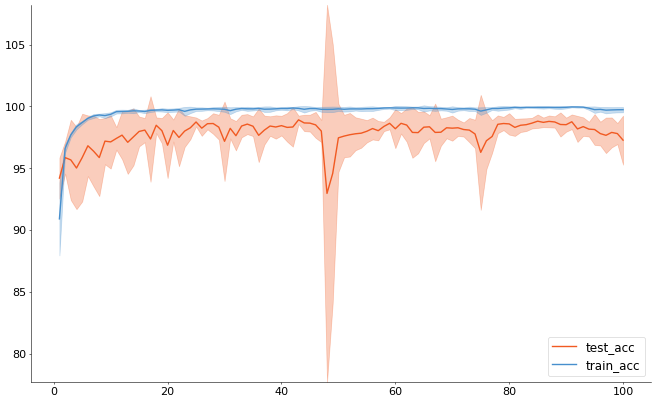

In [10]:
lib = ['#F15A22','#478FCD']
PlotMultiCVCurve({'test_acc':his['test_acc'], 'train_acc':his['train_acc']},
                 color_lib=lib,
                 legend_loc='lower right',
                 dpi=50)

### 6.2 Loss Curves

/PUBLIC/home/jyy/anaconda2/envs/csd2020.2/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


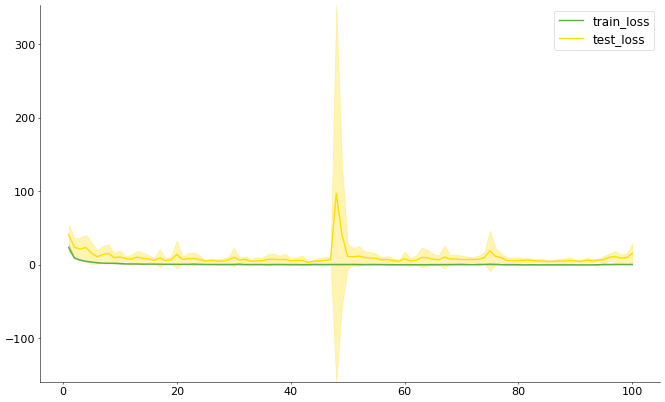

In [11]:
lib = ['#5FAD46','#FFDD00']
PlotMultiCVCurve({'train_loss':his['train_cross_entropy'], 'test_loss':his['test_cross_entropy']},
                 color_lib=lib,
                 legend_loc='upper right',
                 dpi=50)